# CS679 Neural Networks
## Winter 2023 - Final Project
---
**Group member names and UW student ID numbers: **
* _Yujia Zheng (20789867)_
* _Kaiden Liu (20730764)_
* _Yuxuan Liu (20995223)_

## Packages 

THis section imports all required packages.

In [ ]:
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

!pip install transformers
from transformers import BertModel
from transformers import AdamW,get_linear_schedule_with_warmup
from transformers import BertTokenizer, BertForSequenceClassification

import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import RandomSampler, SequentialSampler, DataLoader
from torch.nn.utils import clip_grad_norm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

from sklearn.decomposition import PCA

In [ ]:
import pandas as pd
import numpy as np
import datetime
import re
import math
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson, pearsonr, spearmanr, kendalltau, pointbiserialr
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.compat.v1.keras.backend import set_session

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Sentiment Analysis

### Financial News Data

This financial news dataset found at Kaggle will be used to train our BERT for sentiment analysis.

In [ ]:
financial_news = pd.read_csv("https://git.uwaterloo.ca/ky5liu/cs679_project/-/raw/main/financial_news.csv", 
                             header=None, names = ["label", "text"], 
                             encoding='latin-1')
financial_news

,label,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [ ]:
financial_news["set"] = "train"
financial_news

,label,text,set
0,neutral,"According to Gran , the company has no plans t...",train
1,neutral,Technopolis plans to develop in stages an area...,train
2,negative,The international electronic industry company ...,train
3,positive,With the new production plant the company woul...,train
4,positive,According to the company 's updated strategy f...,train
...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,train
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,train
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,train
4844,negative,Net sales of the Paper segment decreased to EU...,train


### New York Times Microsoft News Data

We scraped Microsoft news using NYTimes API. Data exploration and manipulation will be done in this section.

In [ ]:
nytimes_articles = pd.read_csv("https://git.uwaterloo.ca/ky5liu/cs679_project/-/raw/main/MSFT_nytimes_scraping/nytimes_articles.csv")
nytimes_articles

,headline,abstract,date,url
0,Guess Who's Coming to Davos,"Every year, Klaus Schwab throws the ultimate A...",2005-01-20 05:00:00+00:00,https://www.nytimes.com/2005/01/20/business/wo...
1,Is Your House Overvalued?,"Four days after Alan Greenspan, the Federal Re...",2005-05-28 04:00:00+00:00,https://www.nytimes.com/2005/05/28/business/is...
2,Intel Is Target of Antitrust Suit by Rival Chi...,The chip maker accused Intel of antitrust viol...,2005-06-28 05:00:00+00:00,https://www.nytimes.com/2005/06/28/business/in...
3,Microsoft to Pay I.B.M. $775 Million to Settle...,The settlement stems from the Justice Departme...,2005-07-01 05:00:00+00:00,https://www.nytimes.com/2005/07/01/business/mi...
4,DreamWorks Forecasts Loss and Its Stock Plunges,Shares of DreamWorks Animation fell 13.2 perce...,2005-07-11 05:00:00+00:00,https://www.nytimes.com/2005/07/11/business/dr...
...,...,...,...,...
7149,Why Are Middle-Aged Men Missing From the Labor...,Men ages 35 to 44 are staging a lackluster reb...,2022-12-02 10:00:24+00:00,https://www.nytimes.com/2022/12/02/business/ec...
7150,The Legal Heat Grows for Bankman-Fried,A federal investigation into whether the FTX f...,2022-12-08 13:18:48+00:00,https://www.nytimes.com/2022/12/08/business/de...
7151,Bankman-Fried’s ‘Epic’ Legal Battle,The disgraced crypto entrepreneur was freed on...,2022-12-23 12:21:34+00:00,https://www.nytimes.com/2022/12/23/business/de...
7152,Oil Climbs as Western Nations Single Out Russia,Energy traders pushed crude prices higher on M...,2022-12-05 12:35:40+00:00,https://www.nytimes.com/2022/12/05/business/de...


In [ ]:
# Convert the date to the format of %Y-%m-%d.
nytimes_articles['date'] = pd.to_datetime(nytimes_articles['date'], format = "%Y-%m-%d").dt.tz_localize(None).dt.date
# Sort the data by date in ascending order.
nytimes_articles = nytimes_articles.sort_values(by=['date'])
# Reset and drop the index.
nytimes_articles = nytimes_articles.reset_index(drop=True)
nytimes_articles

,headline,abstract,date,url
0,Guess Who's Coming to Davos,"Every year, Klaus Schwab throws the ultimate A...",2005-01-20,https://www.nytimes.com/2005/01/20/business/wo...
1,Is Your House Overvalued?,"Four days after Alan Greenspan, the Federal Re...",2005-05-28,https://www.nytimes.com/2005/05/28/business/is...
2,Intel Is Target of Antitrust Suit by Rival Chi...,The chip maker accused Intel of antitrust viol...,2005-06-28,https://www.nytimes.com/2005/06/28/business/in...
3,Microsoft to Pay I.B.M. $775 Million to Settle...,The settlement stems from the Justice Departme...,2005-07-01,https://www.nytimes.com/2005/07/01/business/mi...
4,DreamWorks Forecasts Loss and Its Stock Plunges,Shares of DreamWorks Animation fell 13.2 perce...,2005-07-11,https://www.nytimes.com/2005/07/11/business/dr...
...,...,...,...,...
7149,Microsoft Gambles on ‘Nice Guy’ Strategy to Cl...,Federal regulators have sued to block the $69 ...,2022-12-22,https://www.nytimes.com/2022/12/22/technology/...
7150,Bankman-Fried’s ‘Epic’ Legal Battle,The disgraced crypto entrepreneur was freed on...,2022-12-23,https://www.nytimes.com/2022/12/23/business/de...
7151,The Tech That Will Invade Our Lives in 2023,"Say hello to new-and-improved A.I. assistants,...",2022-12-29,https://www.nytimes.com/2022/12/29/technology/...
7152,"Deal-Making Thrived, Then Hit a Road Bump",Mergers and acquisitions activity plunged in t...,2022-12-30,https://www.nytimes.com/2022/12/30/business/de...


In [ ]:
# Select the rows with missing/blank abstract.
missing_abstracts = nytimes_articles.loc[nytimes_articles['abstract'].isna()]

# Get the index of the missing/blank abstract.
missing_abstracts_index = missing_abstracts.index

# Print the index of the missing/blank abstract.
print(missing_abstracts_index)

Int64Index([6733], dtype='int64')


In [ ]:
# Replace the missing/blank abstracts with headline.
nytimes_articles.at[missing_abstracts_index[0],"abstract"] = ""
nytimes_articles.iloc[missing_abstracts_index[0]]

headline    Catch up: Google’s and Microsoft’s profits soa...
abstract                                                     
date                                               2021-04-28
url         https://www.nytimes.com/2021/04/28/business/ca...
Name: 6733, dtype: object

In [ ]:
# Create a text column that contains both headline and abstract.
nytimes_articles["text"] = nytimes_articles["headline"] + " " + nytimes_articles["abstract"]
nytimes_articles

,headline,abstract,date,url,text
0,Guess Who's Coming to Davos,"Every year, Klaus Schwab throws the ultimate A...",2005-01-20,https://www.nytimes.com/2005/01/20/business/wo...,"Guess Who's Coming to Davos Every year, Klaus ..."
1,Is Your House Overvalued?,"Four days after Alan Greenspan, the Federal Re...",2005-05-28,https://www.nytimes.com/2005/05/28/business/is...,Is Your House Overvalued? Four days after Alan...
2,Intel Is Target of Antitrust Suit by Rival Chi...,The chip maker accused Intel of antitrust viol...,2005-06-28,https://www.nytimes.com/2005/06/28/business/in...,Intel Is Target of Antitrust Suit by Rival Chi...
3,Microsoft to Pay I.B.M. $775 Million to Settle...,The settlement stems from the Justice Departme...,2005-07-01,https://www.nytimes.com/2005/07/01/business/mi...,Microsoft to Pay I.B.M. $775 Million to Settle...
4,DreamWorks Forecasts Loss and Its Stock Plunges,Shares of DreamWorks Animation fell 13.2 perce...,2005-07-11,https://www.nytimes.com/2005/07/11/business/dr...,DreamWorks Forecasts Loss and Its Stock Plunge...
...,...,...,...,...,...
7149,Microsoft Gambles on ‘Nice Guy’ Strategy to Cl...,Federal regulators have sued to block the $69 ...,2022-12-22,https://www.nytimes.com/2022/12/22/technology/...,Microsoft Gambles on ‘Nice Guy’ Strategy to Cl...
7150,Bankman-Fried’s ‘Epic’ Legal Battle,The disgraced crypto entrepreneur was freed on...,2022-12-23,https://www.nytimes.com/2022/12/23/business/de...,Bankman-Fried’s ‘Epic’ Legal Battle The disgra...
7151,The Tech That Will Invade Our Lives in 2023,"Say hello to new-and-improved A.I. assistants,...",2022-12-29,https://www.nytimes.com/2022/12/29/technology/...,The Tech That Will Invade Our Lives in 2023 Sa...
7152,"Deal-Making Thrived, Then Hit a Road Bump",Mergers and acquisitions activity plunged in t...,2022-12-30,https://www.nytimes.com/2022/12/30/business/de...,"Deal-Making Thrived, Then Hit a Road Bump Merg..."


In [ ]:
# Check if there are any missing values in text.
print(nytimes_articles["text"].isna().sum())

0


In [ ]:
nytimes_articles_test = nytimes_articles[["date", "text"]]
nytimes_articles_test["set"] = "test"
nytimes_articles_test

<ipython-input-13-2f9b86b88dff>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nytimes_articles_test["set"] = "test"


,date,text,set
0,2005-01-20,"Guess Who's Coming to Davos Every year, Klaus ...",test
1,2005-05-28,Is Your House Overvalued? Four days after Alan...,test
2,2005-06-28,Intel Is Target of Antitrust Suit by Rival Chi...,test
3,2005-07-01,Microsoft to Pay I.B.M. $775 Million to Settle...,test
4,2005-07-11,DreamWorks Forecasts Loss and Its Stock Plunge...,test
...,...,...,...
7149,2022-12-22,Microsoft Gambles on ‘Nice Guy’ Strategy to Cl...,test
7150,2022-12-23,Bankman-Fried’s ‘Epic’ Legal Battle The disgra...,test
7151,2022-12-29,The Tech That Will Invade Our Lives in 2023 Sa...,test
7152,2022-12-30,"Deal-Making Thrived, Then Hit a Road Bump Merg...",test


In [ ]:
# Concatenate financial news and NYTimes Microsoft news.
news = pd.concat([financial_news, nytimes_articles_test], ignore_index = True)
# Change the labels to numeric.
label_map = {"negative": 0, "neutral": 1, "positive": 1}
news["num_label"] = news["label"].apply(lambda x: label_map[x] if x in label_map else -1)
news

,label,text,set,date,num_label
0,neutral,"According to Gran , the company has no plans t...",train,NaN,1
1,neutral,Technopolis plans to develop in stages an area...,train,NaN,1
2,negative,The international electronic industry company ...,train,NaN,0
3,positive,With the new production plant the company woul...,train,NaN,1
4,positive,According to the company 's updated strategy f...,train,NaN,1
...,...,...,...,...,...
11995,NaN,Microsoft Gambles on ‘Nice Guy’ Strategy to Cl...,test,2022-12-22,-1
11996,NaN,Bankman-Fried’s ‘Epic’ Legal Battle The disgra...,test,2022-12-23,-1
11997,NaN,The Tech That Will Invade Our Lives in 2023 Sa...,test,2022-12-29,-1
11998,NaN,"Deal-Making Thrived, Then Hit a Road Bump Merg...",test,2022-12-30,-1


### BERT Model for Sentiment Analysis

In [ ]:
# BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
# Build the training data encoder.
train_encoder = tokenizer.batch_encode_plus(news[news["set"] == "train"].text.values,
                                            add_special_tokens = True,
                                            pad_to_max_length = True,
                                            max_length = 256,
                                            return_tensors = "pt"
                                            )

# input_ids: List of token ids to be fed to a model.
train_input_ids = train_encoder["input_ids"]
# attention_masks: List of indices specifying which tokens should be attended to by the model .
train_attention_masks = train_encoder["attention_mask"]
train_labels = torch.tensor(news[news["set"] == "train"].num_label.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Build the test data encoder.
test_encoder = tokenizer.batch_encode_plus(news[news["set"] == "test"].text.values,
                                      add_special_tokens = True,
                                      pad_to_max_length = True,
                                      max_length = 256,
                                      return_tensors = "pt")

# input_ids: List of token ids to be fed to a model.
test_input_ids = test_encoder["input_ids"]
# attention_masks: List of indices specifying which tokens should be attended to by the model .
test_attention_masks = test_encoder["attention_mask"]
test_labels = torch.tensor(news[news["set"] == "test"].num_label.values)

In [ ]:
# Make a tensor dataset consisting of input_ids, attention_masks and labels.
train_data = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)

In [ ]:
# Create the training and test data loaders.
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size = 16
)

test_dataloader = DataLoader(
    test_data,
    sampler=RandomSampler(test_data),
    batch_size = 16
)

In [ ]:
# Define the BERT model, optimizer, number of epochs and scheduler.
news_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                          num_labels = 2,
                                                          output_attentions = False,
                                                          output_hidden_states =  False)
news_bert.to(device)

optimizer = AdamW(news_bert.parameters(), lr = 1e-4, eps = 1e-8)
num_epoch = 3
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = len(train_dataloader)*num_epoch)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# Set up the training loop.
for epoch in range(num_epoch):
    progress_bar = tqdm(train_dataloader, desc="Epoch {}".format(epoch+1))

    for step, batch in enumerate(progress_bar):
        # Set the model to training mode.
        news_bert.train()

        # Unpack inputs and labels from the batch.
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Clear previously calculated gradients.
        news_bert.zero_grad()

        # Forward pass using the BERT model for news to get logits.
        outputs = news_bert(b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels)

        # Compute loss and perform backward propagation.
        loss = outputs.loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(news_bert.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'loss': loss.item()})

Epoch 1:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/303 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/303 [00:00<?, ?it/s]

In [ ]:
# Set the model to evaluation mode and use it to predict the labels for the test set
news_bert.eval()
test_predictions = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Predicting labels"):
        # Move batch to device.
        batch = tuple(t.to(device) for t in batch)

        # Unpack inputs from the batch.
        b_input_ids, b_input_mask,_ = batch

        # Forward pass to get logits.
        outputs = news_bert(b_input_ids,
                            attention_mask=b_input_mask)

        # Get predicted labels.
        _, pred_labels = torch.max(outputs.logits, dim=1)

        # Convert predicted labels to numpy array and append to test_predictions list.
        pred_labels = pred_labels.cpu().numpy()
        test_predictions.append(pred_labels)

test_predictions = np.concatenate(test_predictions)

Predicting labels:   0%|          | 0/448 [00:00<?, ?it/s]

In [ ]:
nytimes_articles["pred_sentiment"] = test_predictions
unique_vals, counts = np.unique(test_predictions, return_counts=True)

# Print the results.
for val, count in zip(unique_vals, counts):
    print(f"{val}: {count}")

0: 1003
1: 6151


In [ ]:
# Take a look at the predicted sentiments.
nytimes_articles[["date", "abstract", "pred_sentiment"]]

,date,abstract,pred_sentiment
0,2005-01-20,"Every year, Klaus Schwab throws the ultimate A...",1
1,2005-05-28,"Four days after Alan Greenspan, the Federal Re...",1
2,2005-06-28,The chip maker accused Intel of antitrust viol...,1
3,2005-07-01,The settlement stems from the Justice Departme...,1
4,2005-07-11,Shares of DreamWorks Animation fell 13.2 perce...,1
...,...,...,...
7149,2022-12-22,Federal regulators have sued to block the $69 ...,1
7150,2022-12-23,The disgraced crypto entrepreneur was freed on...,1
7151,2022-12-29,"Say hello to new-and-improved A.I. assistants,...",1
7152,2022-12-30,Mergers and acquisitions activity plunged in t...,1


## Stock Price Prediction

### From Predicted Sentiment to Number of Good/Bad News Per Day

In this section, we converted the predicted sentiment into two new features: the number of good news per day and the number of bad news per day.

In [ ]:
news_pred = nytimes_articles[["date", "pred_sentiment"]]
#news_types["num_good"] = news_types.groupby("num_good")
news_pred

,date,pred_sentiment
0,2005-01-20,1
1,2005-05-28,1
2,2005-06-28,1
3,2005-07-01,1
4,2005-07-11,1
...,...,...
7149,2022-12-22,1
7150,2022-12-23,1
7151,2022-12-29,1
7152,2022-12-30,1


In [ ]:
# Total number of news each day.
total_news = news_pred.groupby(['date']).count()
news_type = pd.DataFrame(total_news).reset_index(drop=False)
news_type = news_type.rename(columns={"pred_sentiment": "total"})
news_type

,date,total
0,2005-01-20,1
1,2005-05-28,1
2,2005-06-28,1
3,2005-07-01,1
4,2005-07-11,2
...,...,...
3658,2022-12-21,1
3659,2022-12-22,1
3660,2022-12-23,1
3661,2022-12-29,1


In [ ]:
# Number of good news each day.
num_good = list(news_pred.groupby(['date']).sum()["pred_sentiment"])
news_type["num_good"] = num_good

# Number of bad news each day.
news_type["num_bad"] = news_type["total"] - news_type["num_good"]
news_type

,date,total,num_good,num_bad
0,2005-01-20,1,1,0
1,2005-05-28,1,1,0
2,2005-06-28,1,1,0
3,2005-07-01,1,1,0
4,2005-07-11,2,2,0
...,...,...,...,...
3658,2022-12-21,1,1,0
3659,2022-12-22,1,1,0
3660,2022-12-23,1,1,0
3661,2022-12-29,1,1,0


In [ ]:
news_type.to_csv("news_type.csv", index=False)

### Scoring Function

In this section, we defined a function for computing the sentiment score and added the derived features to news_type dataset.


In [ ]:
news_type = pd.read_csv("news_type.csv")
news_type["date"] = pd.to_datetime(news_type["date"])
news_type

,date,total,num_good,num_bad
0,2005-01-20,1,1,0
1,2005-05-28,1,1,0
2,2005-06-28,1,1,0
3,2005-07-01,1,1,0
4,2005-07-11,2,1,1
...,...,...,...,...
3658,2022-12-21,1,1,0
3659,2022-12-22,1,1,0
3660,2022-12-23,1,1,0
3661,2022-12-29,1,0,1


In [ ]:
def sentiment_score(df, lookback_days, c, method='mean', normalize = False):
    # Set the date column as the index.
    df = df.set_index('date')

    # Create a new DataFrame with all dates in the range of the input data.
    full_index = pd.date_range(df.index.min(), df.index.max())
    full_df = pd.DataFrame(index=full_index)

    # Merge the input data into the new DataFrame, filling missing values with 0.
    full_df = full_df.merge(df, how='left', left_index=True, right_index=True).fillna(0)


    # Parameters for future calculations.
    alpha = 2 / (lookback_days + 1)

    # Calculate rolling averages of good and bad news over the previous lookback_days.
    if method == 'mean':
        rolling_good = full_df['num_good'].rolling(f'{lookback_days}D').mean().shift(1).fillna(0)
        rolling_bad = full_df['num_bad'].rolling(f'{lookback_days}D').mean().shift(1).fillna(0)
    elif method == 'min':
        rolling_good = full_df['num_good'].replace(0, np.nan).rolling(f'{lookback_days}D').min().shift(1).replace(np.nan, 0)
        rolling_bad = full_df['num_bad'].replace(0, np.nan).rolling(f'{lookback_days}D').min().shift(1).replace(np.nan, 0)
    # elif method == 'poisson':
    #     rolling_mean_good = full_df['num_good'].rolling(f'{lookback_days}D').mean().shift(1)\
    #       .fillna(0).apply(lambda x: math.ceil(x)).astype(int)
    #     rolling_mean_bad = full_df['num_bad'].rolling(f'{lookback_days}D').mean().shift(1)\
    #       .fillna(0).apply(lambda x: math.ceil(x)).astype(int)
    #     rolling_good = poisson.rvs(rolling_mean_good, 1)
    #     rolling_bad = poisson.rvs(rolling_mean_bad, 1)
    # elif method == 'normal':
    #     mean_good = full_df['num_good'].mean()
    #     std_good = full_df['num_good'].std()
    #     mean_bad = full_df['num_bad'].mean()
    #     std_bad = full_df['num_bad'].std()
    #     rolling_good = norm.rvs(loc=mean_good, scale=std_good, size=len(full_df))
    #     rolling_bad = norm.rvs(loc=mean_bad, scale=std_bad, size=len(full_df))

    elif method == 'exponential':
        # Calculate the exponential moving averages of good and bad news over the previous lookback_days.
        rolling_good = full_df['num_good'].ewm(adjust=False, span=lookback_days).mean().shift(1).fillna(0)
        rolling_bad = full_df['num_bad'].ewm(adjust=False, span=lookback_days).mean().shift(1).fillna(0)
    else:
        raise ValueError(f"Method {method} not recognized.")

    # Scale the rolling averages by the scaling factors in c.
    rolling_good_scaled = abs(rolling_good) * c[0]
    rolling_bad_scaled = abs(rolling_bad) * c[1]

    # Add the scaled rolling averages to the original columns.
    full_df['adjusted_num_good'] = full_df['num_good'] + rolling_good_scaled
    full_df['adjusted_num_bad'] = full_df['num_bad'] + rolling_bad_scaled

    if normalize:
        # Calculate the proportion of adjusted_num_good.
        full_df['adjusted_num_good_prop'] = full_df['adjusted_num_good'] / (full_df['adjusted_num_good'] + full_df['adjusted_num_bad'])

        # Calculate the proportion of adjusted_num_bad.
        full_df['adjusted_num_bad_prop'] = full_df['adjusted_num_bad'] / (full_df['adjusted_num_good'] + full_df['adjusted_num_bad'])

    # Add the rolling averages as new columns.
    full_df['rolling_good'] = rolling_good
    full_df['rolling_bad'] = rolling_bad

    # Reset the index to make the date column a regular column.
    full_df = full_df.reset_index()
    full_df = full_df.rename(columns={'index': 'date'})

    return full_df


In [ ]:
new_type_exp_adj = sentiment_score(df=news_type, lookback_days=10, c=[5,5], method="exponential")

### Hyperparameter Tuning 


#### Hyperparameter Tuning Functions

In [ ]:
def join_tables_on_date(table1, table2):
    """
    Joins two tables on their "date" and "Date" columns using an inner join.
    Assumes table1 has a "date" column and table2 has a "Date" column, and both
    columns contain date values in a compatible format.
    Returns a new table that includes all columns from table1 and the "Close"
    column from table2.
    """
    # Convert the "date" column in table1 to datetime format.
    table1["date"] = pd.to_datetime(table1["date"])

    # Convert the "Date" column in table2 to datetime format.
    table2["Date"] = pd.to_datetime(table2["Date"])

    # Set the "date" and "Date" columns as the indices for table1 and table2, respectively.
    table1.set_index("date", inplace=True)
    table2.set_index("Date", inplace=True)

    # Join the two tables on their indices using an inner join.
    result = pd.concat([table1, table2], axis=1, join="inner")

    # Reset the index for the result table.
    result.reset_index(inplace=True)
    table1.reset_index(inplace=True)
    table2.reset_index(inplace=True)
    return result


In [ ]:
def calculate_correlations(features, output, data):
    """
    Calculates Pearson's correlation coefficient, Spearman's rank correlation coefficient, Kendall's Tau, and
    point biserial correlation coefficient between a list of features and an output variable.
    :param features: List of feature column names
    :param output: Output variable column name
    :param data: Pandas DataFrame containing the dataset
    :return: Dictionary containing the correlation coefficients for each feature
    """
    correlations = {}
    for feature in features:
        # Pearson's correlation coefficient.
        r, p = pearsonr(data[feature], data[output])
        # Spearman's rank correlation coefficient.
        rho, pval = spearmanr(data[feature], data[output])
        # Kendall's Tau.
        tau, pval = kendalltau(data[feature], data[output])
        # Point biserial correlation coefficient.
        rpb, pval = pointbiserialr(data[feature], data[output])
        
        # Add the correlation coefficients to the dictionary.
        correlations[feature] = {'pearson': r, 'spearman': rho, 'kendall': tau, 'point_biserial': rpb}
        
    return correlations


#### Tuning Setup

In [ ]:
MSFT_stats = pd.read_csv("https://git.uwaterloo.ca/ky5liu/cs679_project/-/raw/main/MSFT_stats/MSFT_stats.csv")
MSFT_stats["Date"] = pd.to_datetime(MSFT_stats["Date"], format = "%Y-%m-%d")
############
# Create a new trend variable.
MSFT_stats['Trend'] = MSFT_stats['Close'] > MSFT_stats['Close'].shift(1)
MSFT_stats['Trend'] = MSFT_stats['Trend'].astype(int)
############
# Create a new movement variable.
MSFT_stats['Movement'] = ((MSFT_stats['Close'] - MSFT_stats['Close'].shift(1)) / MSFT_stats['Close'].shift(1)) 

  0%|          | 0/20 [00:00<?, ?it/s]

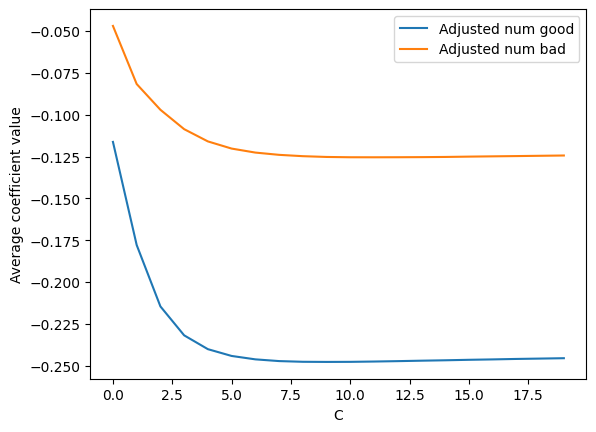

11

In [ ]:
features = ["adjusted_num_good","adjusted_num_bad"]
output = "Close"

# Define the range of C values to test.
c_range = np.linspace(0, 20, 20)

# Define an empty dictionary to store the average coefficients.
avg_good = []
avg_bad = []

# Iterate over the range of C values.
for i in tqdm(c_range):
    # Calculate the sentiment score with the current C value.
    new_type_exp_adj = sentiment_score(df=news_type, lookback_days=10, c=[i, i], method="exponential")
    C_tuning = join_tables_on_date(new_type_exp_adj, MSFT_stats)
    C_tuning = C_tuning[[*features, output]]

    # Calculate the correlation coefficients.
    correlations = calculate_correlations(features, output, C_tuning)

    coeffs = correlations["adjusted_num_good"]
    # Calculate the average of the values.
    avg_good.append(sum(coeffs.values()) / len(coeffs.values()))
    coeffs = correlations["adjusted_num_bad"]
    # Calculate the average of the values.
    avg_bad.append(sum(coeffs.values()) / len(coeffs.values()))


# Plot the average coefficients for each key.
plt.plot(avg_good, label='Adjusted num good')
plt.plot(avg_bad, label='Adjusted num bad')

# Add axis labels and legend.
plt.xlabel('C')
plt.ylabel('Average coefficient value')
plt.legend()
plt.show()

avg_good.index(min(avg_good))
avg_bad.index(min(avg_bad))

# C = [5,5] for exponential, mean.
# min performs very bad.
# trend and smoothed mean correlation is low.


We choose to use c = [5,5] with close price as the response variable.

### Model

#### Merge Microsoft News and Sentiment Analysis Result by Date

In [ ]:
# Read the stock price dataset.
MSFT_stats = pd.read_csv("https://git.uwaterloo.ca/ky5liu/cs679_project/-/raw/main/MSFT_stats/MSFT_stats.csv")

In [ ]:
# Convert the date to DateTime object. 
MSFT_stats["Date"] = pd.to_datetime(MSFT_stats["Date"], format = "%Y-%m-%d")
MSFT_stats

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,FED_rate,GDP,CPI
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060657,1.031789e+09,0.0,0.0,7.56,4507.894,109.100
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062823,3.081600e+08,0.0,0.0,7.39,4507.894,109.100
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063907,1.331712e+08,0.0,0.0,7.60,4507.894,109.100
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062281,6.776640e+07,0.0,0.0,7.55,4507.894,109.100
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061198,4.789440e+07,0.0,0.0,7.38,4507.894,109.100
...,...,...,...,...,...,...,...,...,...,...,...,...
9334,2023-03-27,280.500000,281.459991,275.519989,276.380005,276.380005,2.684020e+07,0.0,0.0,4.83,25723.941,301.648
9335,2023-03-28,275.790009,276.140015,272.049988,275.230011,275.230011,2.187860e+07,0.0,0.0,4.83,25723.941,301.648
9336,2023-03-29,278.959991,281.140015,278.410004,280.510010,280.510010,2.508700e+07,0.0,0.0,4.83,25723.941,301.648
9337,2023-03-30,284.230011,284.459991,281.480011,284.049988,284.049988,2.505340e+07,0.0,0.0,4.83,25723.941,301.648


In [ ]:
MSFT_merged = pd.merge(MSFT_stats, new_type_exp_adj, left_on='Date', right_on='date', how='inner')
# Keep some potentially useful variables after the join.
MSFT_merged = MSFT_merged[["Date", "Close", "Volume", "Dividends", "Stock Splits", "FED_rate", "GDP", "CPI", "adjusted_num_good", "adjusted_num_bad"]]
MSFT_merged = MSFT_merged.rename(columns={"adjusted_num_good": "good_news_score", "adjusted_num_bad": "bad_news_score"})
MSFT_merged

,Date,Close,Volume,Dividends,Stock Splits,FED_rate,GDP,CPI,good_news_score,bad_news_score
0,2005-01-20,25.860001,58380100.0,0.0,0.0,2.25,12527.214,191.70,1.000000,0.000000
1,2005-01-21,25.650000,76501000.0,0.0,0.0,2.26,12527.214,191.70,5.000000,0.000000
2,2005-01-24,25.670000,69010900.0,0.0,0.0,2.26,12527.214,191.70,2.738542,0.000000
3,2005-01-25,26.020000,67580700.0,0.0,0.0,2.29,12527.214,191.70,2.240626,0.000000
4,2005-01-26,26.010000,64974500.0,0.0,0.0,2.33,12527.214,191.70,1.833239,0.000000
...,...,...,...,...,...,...,...,...,...,...
4514,2022-12-23,238.729996,21207000.0,0.0,0.0,4.33,25723.941,298.99,4.347170,0.573190
4515,2022-12-27,236.960007,16688600.0,0.0,0.0,4.33,25723.941,298.99,1.997868,0.256861
4516,2022-12-28,234.529999,17457100.0,0.0,0.0,4.33,25723.941,298.99,1.634619,0.210159
4517,2022-12-29,241.009995,19770700.0,0.0,0.0,4.33,25723.941,298.99,1.337416,1.171948


In [ ]:
# Drop first row.
MSFT_merged = MSFT_merged.drop(index=0)

# Check the NAs in the final dataframe.
MSFT_merged.isna().sum()

Date               0
Close              0
Volume             0
Dividends          0
Stock Splits       0
FED_rate           0
GDP                0
CPI                0
good_news_score    0
bad_news_score     0
dtype: int64

#### Check for low correlation features


In [ ]:
correlations = calculate_correlations(list(MSFT_merged.columns)[2:], "Close", MSFT_merged)

for feature, coeffs in correlations.items():
    print('Correlation coefficients for %s:' % feature)
    print('Pearson: %.3f' % coeffs['pearson'])
    print('Spearman: %.3f' % coeffs['spearman'])
    print('Kendall: %.3f' % coeffs['kendall'])
    print('Point biserial: %.3f' % coeffs['point_biserial'])
    print()

Correlation coefficients for Volume:
Pearson: -0.376
Spearman: -0.683
Kendall: -0.477
Point biserial: -0.376

Correlation coefficients for Dividends:
Pearson: 0.058
Spearman: 0.001
Kendall: 0.001
Point biserial: 0.058

Correlation coefficients for Stock Splits:
Pearson: nan
Spearman: nan
Kendall: nan
Point biserial: nan

Correlation coefficients for FED_rate:
Pearson: -0.144
Spearman: -0.170
Kendall: -0.080
Point biserial: -0.144

Correlation coefficients for GDP:
Pearson: 0.889
Spearman: 0.919
Kendall: 0.784
Point biserial: 0.889

Correlation coefficients for CPI:
Pearson: 0.864
Spearman: 0.918
Kendall: 0.791
Point biserial: 0.864

Correlation coefficients for good_news_score:
Pearson: -0.296
Spearman: -0.228
Kendall: -0.163
Point biserial: -0.296

Correlation coefficients for bad_news_score:
Pearson: -0.162
Spearman: -0.102
Kendall: -0.072
Point biserial: -0.162



/usr/local/lib/python3.9/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.9/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


We can see that dividends and stock splits almost have no correlations with the target stock price.

In [ ]:
# Exclude the lowest-correlated variables, determine the variables we want to include in the final model.
MSFT_merged = MSFT_merged.drop(["Date", "Volume"], axis=1)
MSFT_merged

,Close,Dividends,Stock Splits,FED_rate,GDP,CPI,good_news_score,bad_news_score
1,25.650000,0.0,0.0,2.26,12527.214,191.70,5.000000,0.000000
2,25.670000,0.0,0.0,2.26,12527.214,191.70,2.738542,0.000000
3,26.020000,0.0,0.0,2.29,12527.214,191.70,2.240626,0.000000
4,26.010000,0.0,0.0,2.33,12527.214,191.70,1.833239,0.000000
5,26.110001,0.0,0.0,2.39,12527.214,191.70,1.499923,0.000000
...,...,...,...,...,...,...,...,...
4514,238.729996,0.0,0.0,4.33,25723.941,298.99,4.347170,0.573190
4515,236.960007,0.0,0.0,4.33,25723.941,298.99,1.997868,0.256861
4516,234.529999,0.0,0.0,4.33,25723.941,298.99,1.634619,0.210159
4517,241.009995,0.0,0.0,4.33,25723.941,298.99,1.337416,1.171948


#### Actual Model

In [ ]:
# Check the device.
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
def LSTM_train(data=MSFT_merged, features=["Close", "good_news_score", "bad_news_score"], batch_size=32, epochs=50): 
    # Limit TensorFlow GPU memory usage.
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.5
    set_session(tf.compat.v1.Session(config=config))

    # Tune parameters.
    data = data.filter(features)
    num_steps = 10
    trainset_size = 0.975

    # Create a list for target.
    target = data["Close"].values

    # Convert the dataframe to a numpy array.
    dataset = data.values
    # Get the number of rows to train the model on.
    training_data_len = int(np.ceil(len(dataset) * trainset_size ))
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)

    # Create the training data set .
    # Create the scaled training data set.
    train_data = scaled_data[0:int(training_data_len), :]
    # Split the data into x_train and y_train data sets.
    x_train = []
    y_train = []

    # For only lags.
    for i in range(num_steps, len(train_data)):
        x_train.append(train_data[i-num_steps:i, :])
        y_train.append(train_data[i, 0])

    # Convert the x_train and y_train to numpy arrays .
    x_train, y_train = np.array(x_train), np.array(y_train)

    num_features = len(features)

    # Reshape the data.
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], num_features))
    ##############################################################################
    # Build the LSTM model.
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], num_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(16, return_sequences=False))
    model.add(Dense(num_features, activation='relu'))

    # Compile the model.
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Train the model.
    model.fit(x_train, y_train, batch_size, epochs)
    weights = model.get_weights()

    predictions, rmse = LSTM_evaluate(model, scaler, scaled_data, data, training_data_len, num_steps, num_features)

    return model, weights, training_data_len, predictions, rmse

In [ ]:
#################################################################
def LSTM_evaluate(model, scaler, scaled_data, data, training_data_len, num_steps, num_features):
    # Create the testing data set.
    # Create a new array containing scaled values from index 1543 to 2002. 
    test_data = scaled_data[training_data_len - num_steps: , :]

    test_size = len(data) - training_data_len
    # Create the data sets x_test and y_test.
    x_test = []

    # When only using lag.
    y_test = test_data[-test_size:,:]
    for i in range(num_steps, len(test_data)):
        x_test.append(test_data[i-num_steps:i, :])

    # Convert the data to a numpy array with dtype=object.
    x_test = np.array(x_test, dtype=object)

    # Reshape the data.
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], num_features))
    x_test = x_test.astype('float32')
    # Get the models predicted price values .
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # Get the root mean squared error (RMSE).
    rmse = np.sqrt(np.mean(((predictions[:,0] - y_test[:,0]) ** 2)))

    # (x_train, y_train, batch_size=32, epochs=10) with only close-60 lag, rmse: 252.0112419613703
    return predictions, rmse

In [ ]:
def compute_LCC(data, training_data_len, predictions):
    # Assuming your predicted values are stored in the variable y_hat
    # and your actual values are stored in the variable y
    # Convert them to numpy arrays
    y_test = data[training_data_len:]
    y = np.array(y_test)[:,0]
    y_hat = np.array(predictions)[:,0]

    # Assuming your predicted values are stored in the variable y_hat
    # and your actual values are stored in the variable y
    # Convert them to pandas Series
    y = pd.Series(y)
    y_hat = pd.Series(y_hat)

    # Define the maximum time lag to consider
    max_lag = 10

    # Calculate the lagged correlation coefficient (LCC)
    LCC = [y.corr(y_hat.shift(l)) for l in range(1, max_lag+1)]

    return LCC

In [ ]:
features_comb = [["Close",],
                 ["Close", "FED_rate", "GDP", "CPI"], 
                 ["Close", "FED_rate", "GDP", "CPI", "good_news_score", "bad_news_score"], 
                 ["Close", "Dividends", "Stock Splits", "FED_rate", "GDP", "CPI", "good_news_score", "bad_news_score"], 
                 ["Close", "good_news_score", "bad_news_score"]]

#features = ["Close", "good_news_score", "bad_news_score"]
weights_lst, predictions_lst, rmse_lst, LCC_lst, model_lst = [], [], [], [], []

for features in features_comb:
    model, weights, training_data_len, predictions, rmse = LSTM_train(data=MSFT_merged, 
                                                               features=features, 
                                                               batch_size=32, 
                                                               epochs=50)
    LCC = compute_LCC(data=MSFT_merged, training_data_len=training_data_len, predictions=predictions)
    weights_lst.append(weights)
    predictions_lst.append(predictions)
    rmse_lst.append(rmse)
    LCC_lst.append(LCC)
    model_lst.append(model)

In [ ]:
max_LCC = [max(LCC) for LCC in LCC_lst]
mean_LCC = [sum(LCC)/len(LCC) for LCC in LCC_lst]
print(features_comb)
print(max_LCC)
print(mean_LCC)
print(rmse_lst)

[['Close'], ['Close', 'FED_rate', 'GDP', 'CPI'], ['Close', 'FED_rate', 'GDP', 'CPI', 'good_news_score', 'bad_news_score'], ['Close', 'Dividends', 'Stock Splits', 'FED_rate', 'GDP', 'CPI', 'good_news_score', 'bad_news_score'], ['Close', 'good_news_score', 'bad_news_score']]
[0.8384019890649944, 0.8530052577811913, 0.8443234115869576, 0.8456176423702926, 0.8387628141483944]
[0.7070279010882383, 0.7385612522424971, 0.7229917978340745, 0.7281721692695092, 0.705035068928641]
[249.7644811838456, 245.30673151359045, 244.0785711149001, 248.5744027971725, 252.52467091197335]


In [ ]:
y_test = MSFT_merged.iloc[training_data_len:,0]
y_test = list(y_test)
y_test_diff = [y_test[i] - y_test[i-1] for i in range(1, len(y_test))]
y_test_diff_sign = np.sign(y_test_diff).tolist

actual_peak_price = np.max(y_test)
predicted_peak_price = [np.max(predictions[:,0]) for predictions in predictions_lst]
diff_peak_price = np.abs(predicted_peak_price - actual_peak_price)

actual_peak_date = np.argmax(y_test)
predicted_peak_date = [np.argmax(predictions[:,0]) for predictions in predictions_lst]
diff_peak_date = predicted_peak_date - actual_peak_date

y_bar = np.mean(y_test)
tss = np.sum((y_test - y_bar)**2)
r2_scores = [(1 - (np.sum((y_test - y_pred[:,0])**2)/tss)) for y_pred in predictions_lst]


y_pred_diff = [[y_pred[i] - y_pred[i-1] for i in range(1, len(y_pred))] for y_pred in predictions_lst]
y_pred_diff_sign = [np.sign(diff) for diff in y_pred_diff]


print("Actual peak price:", actual_peak_price)
print("Predicted peak price for each model:", predicted_peak_price)
print("Difference between predicted and actual peak price for each model:", diff_peak_price)
print("Actual peak date:", actual_peak_date)
print("Predicted peak date for each model:", predicted_peak_date)
print("Difference between predicted and actual peak date for each model:", diff_peak_date)

print("The model that leads to the smallest difference in predicted and actual peak price:", features_comb[np.argmin(diff_peak_price)])
print("The model that leads to the smallest difference in predicted and actual peak date:", features_comb[np.argmin(diff_peak_date)])
print("The model that leads to the highest R^2:", features_comb[np.argmax(r2_scores)])
# print("The features for the best model:", features_comb[np.argmin(diff_peak_price)])

In [ ]:
y_test = list(y_test)
y_test_diff = [y_test[i] - y_test[i-1] for i in range(1, len(y_test))]
y_test_diff_sign = np.sign(y_test_diff)

y_pred = [(predictions[:,0]) for predictions in predictions_lst]
test = np.array(y_pred)[4,:]

test.tolist()
test_sign = []
for i in range(len(test)-1):
  test_sign.append(test[i+1]-test[i])

sum(np.sign(np.array(test_sign))== np.sign(y_test_diff))/111

0.4774774774774775

32 batch size, 100 epoch
Actual peak price: 293.4700012207031
Predicted peak price for each model: [284.24234, 275.76526, 281.4612, 291.13818, 269.07266, 282.8805]
Difference between predicted and actual peak price for each model: [ 9.227661  17.704742  12.008789   2.3318176 24.397339  10.589508 ]
Actual peak date: 15
Predicted peak date for each model: [18, 19, 19, 19, 18, 19]
Difference between predicted and actual peak date for each model: [3 4 4 4 3 4]
The model that leads to the smallest difference in predicted and actual peak price: ['Close', 'FED_rate', 'GDP', 'CPI', 'good_news_score', 'bad_news_score']
The model that leads to the smallest difference in predicted and actual peak date: ['Close', 'FED_rate', 'GDP', 'CPI']
The model that leads to the highest R^2: ['Close', 'FED_rate', 'GDP', 'CPI']
The features for the best model: ['Close', 'FED_rate', 'GDP', 'CPI', 'good_news_score', 'bad_news_score']

<ipython-input-71-d5bfb93cb608>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions[:,0]


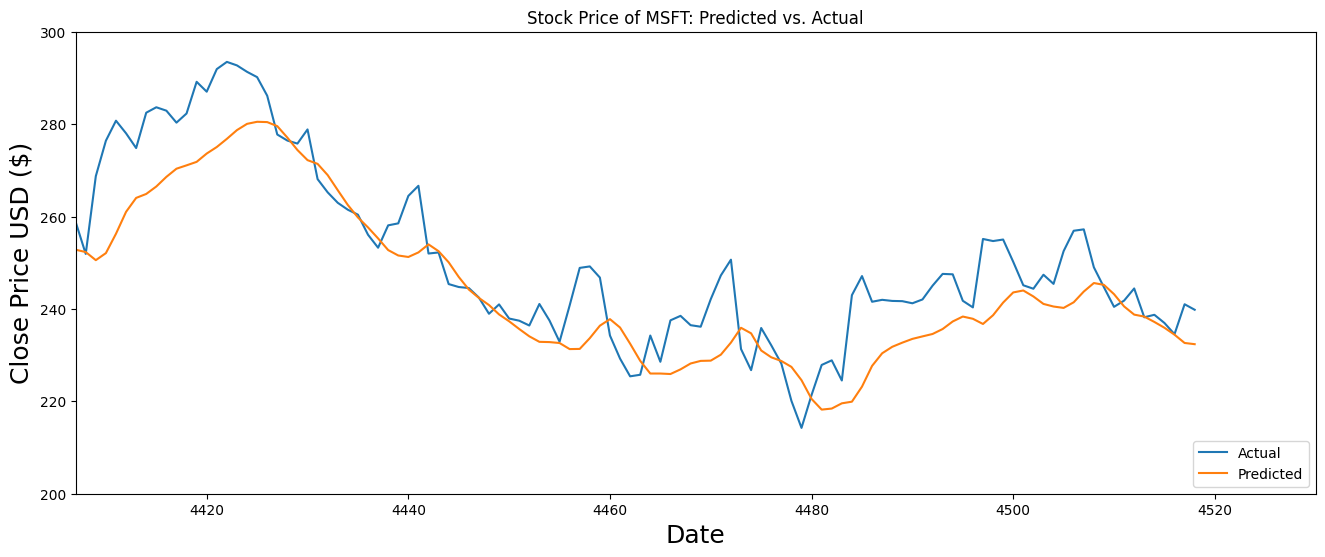

<ipython-input-71-d5bfb93cb608>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions[:,0]


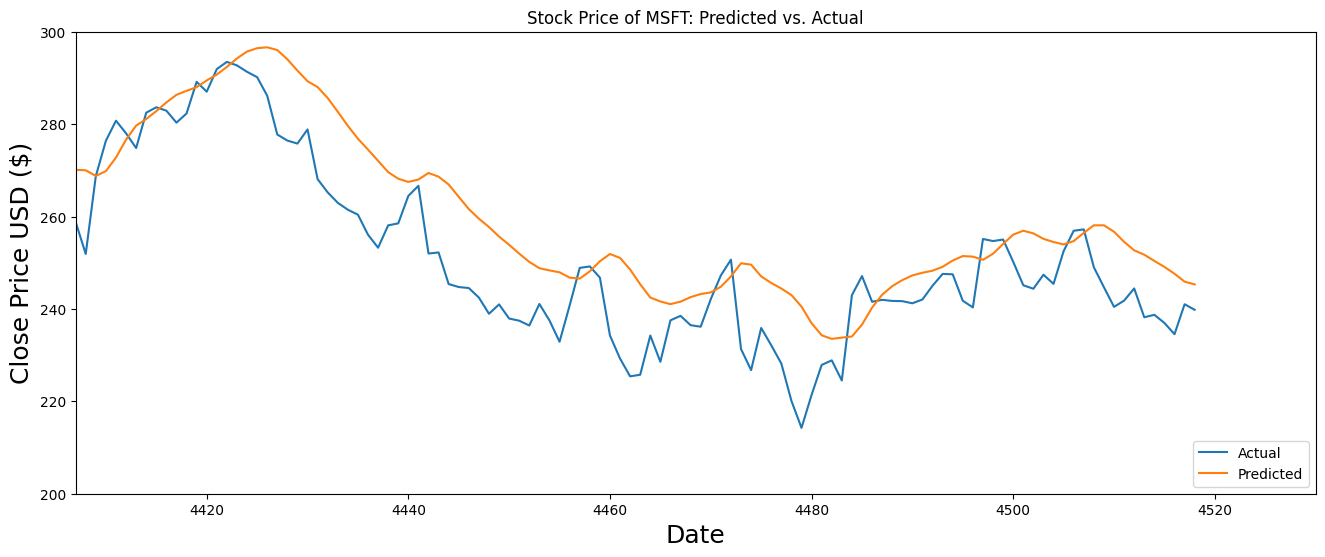

<ipython-input-71-d5bfb93cb608>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions[:,0]


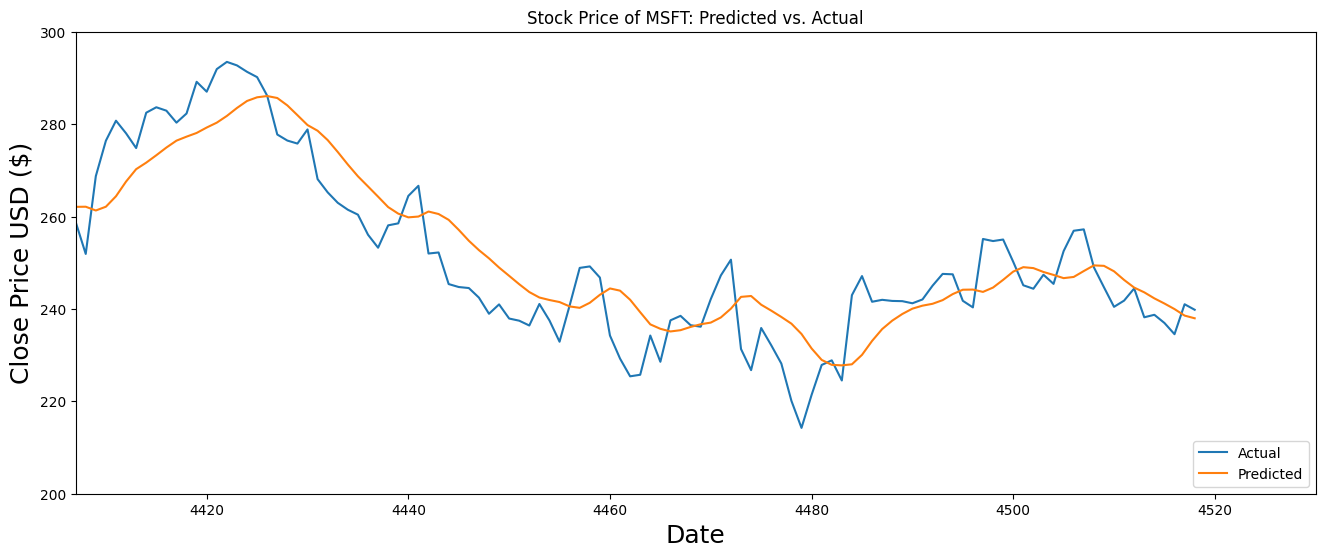

<ipython-input-71-d5bfb93cb608>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions[:,0]


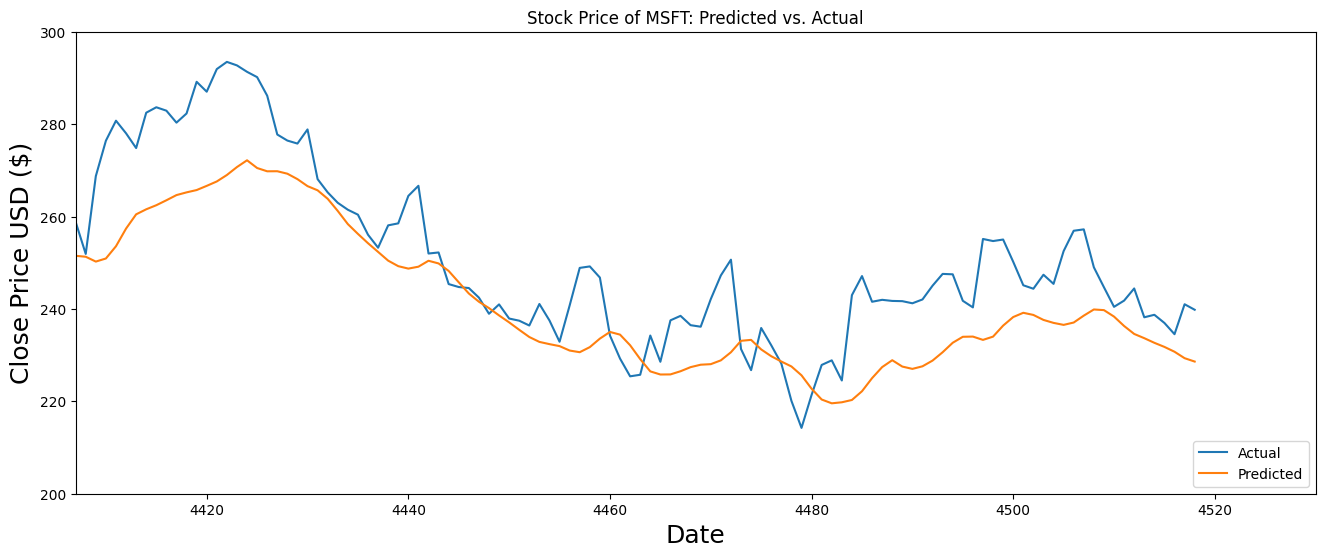

<ipython-input-71-d5bfb93cb608>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions[:,0]


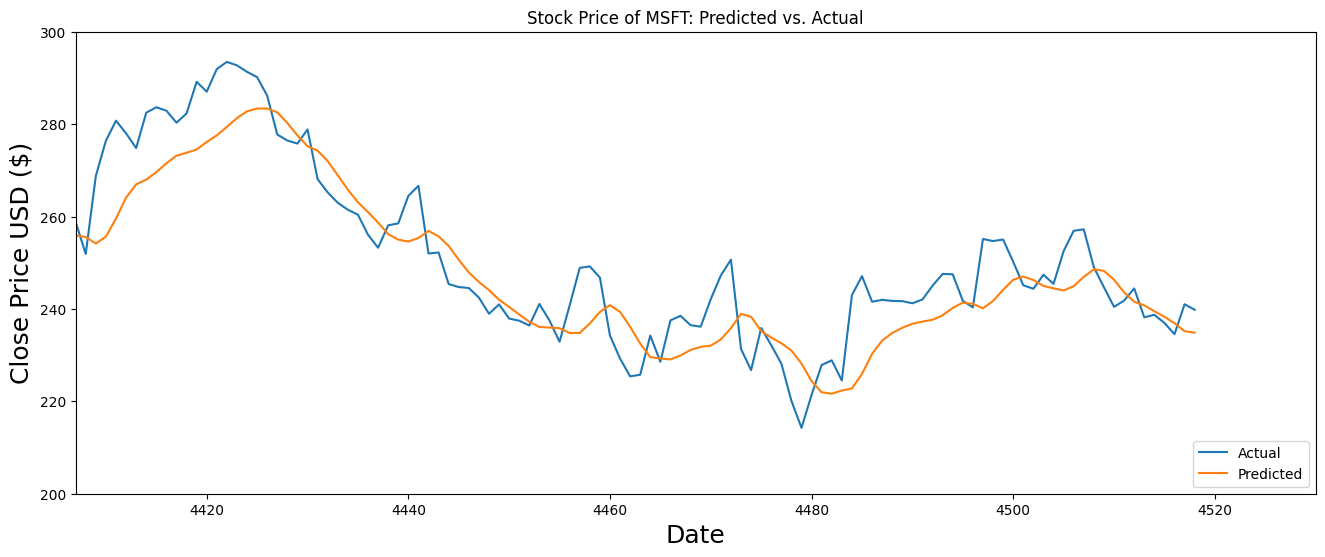

In [ ]:
# Plot the data.
for predictions in predictions_lst:
    # train = MSFT_merged[:training_data_len]
    valid = MSFT_merged[training_data_len:]
    valid['Predictions'] = predictions[:,0]
    # Visualize the data.
    plt.figure(figsize=(16,6))
    plt.title('Stock Price of MSFT: Predicted vs. Actual')
    plt.xlabel('Date', fontsize=18)
    plt.xlim([4407,4530])
    plt.ylim([200,300])
    plt.ylabel('Close Price USD ($)', fontsize=18)
    # plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Actual', 'Predicted'], loc='lower right')
    plt.show()


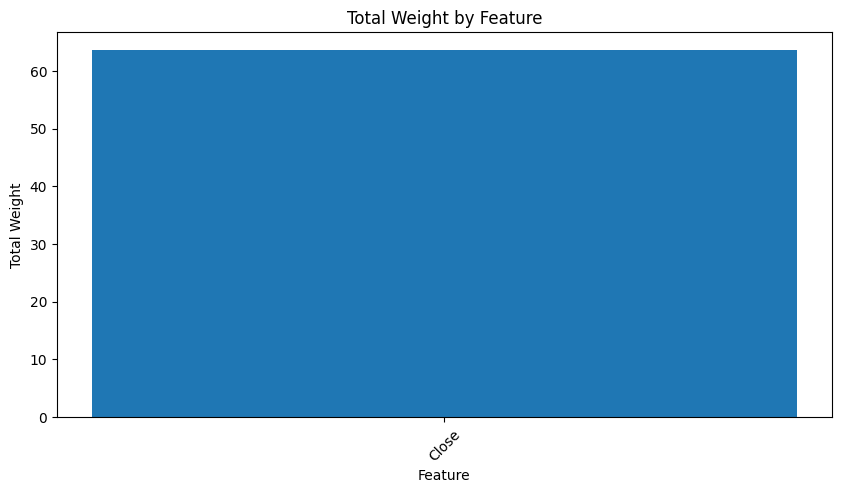

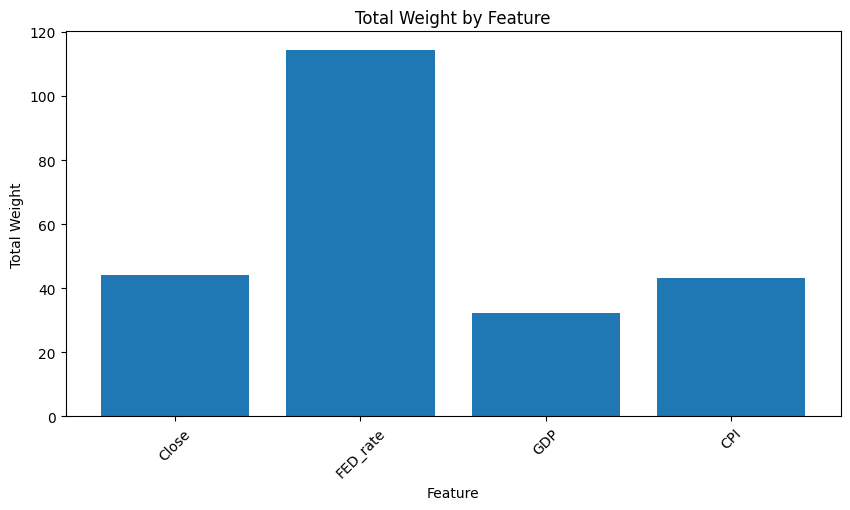

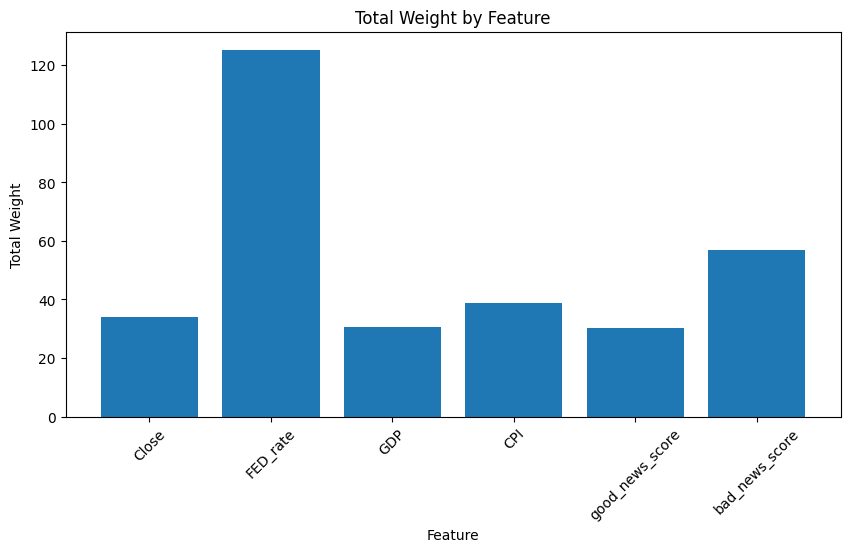

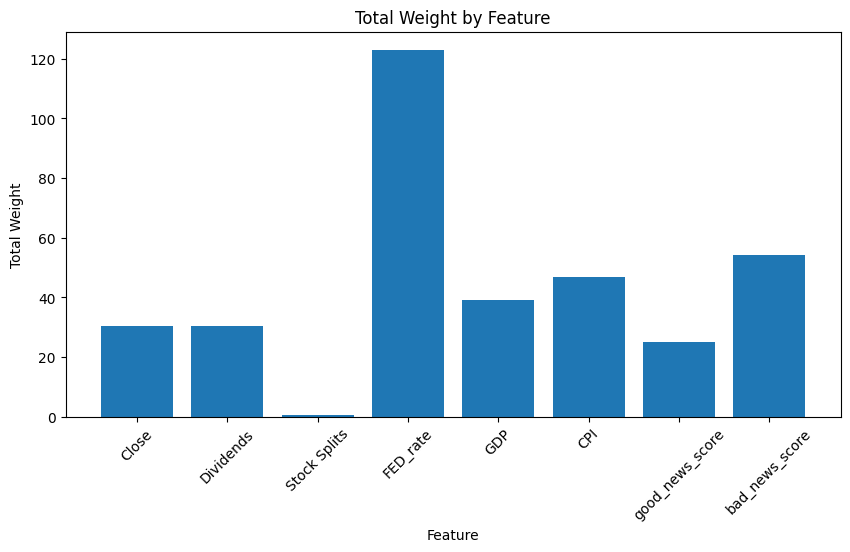

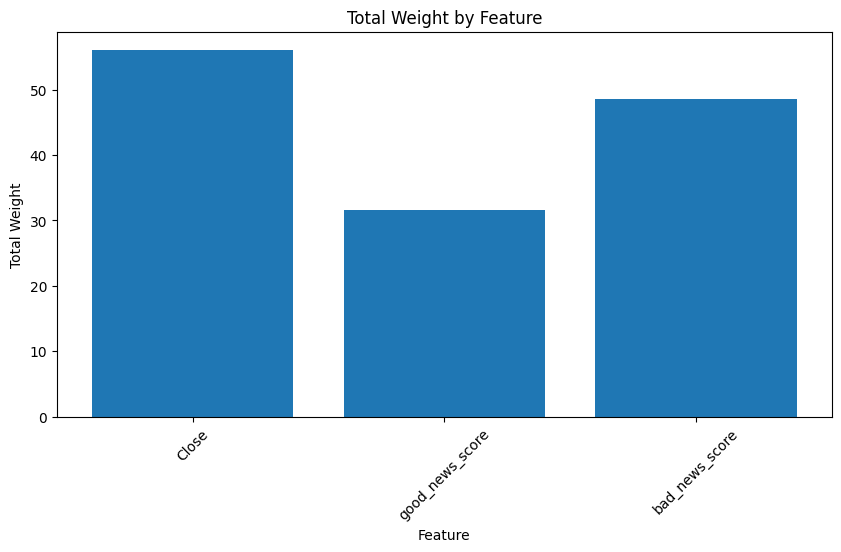

In [ ]:
for features, weights in zip(features_comb, weights_lst):
    # Get the weights of the first LSTM layer.
    # Set the figure size.
    plt.figure(figsize=(10, 5))

    # Set the bar names and heights.
    bar_names = features
    bar_heights = np.sum(weights[0], axis=1)
    len(weights[0])
    # Create a list of colors based on the sign of the weights.
    #colors = ['green' if w >= 0 else 'red' for w in bar_heights]

    # Create the bar chart and set the color of each bar.
    plt.bar(bar_names, abs(bar_heights))

    # Set the chart title and axis labels.
    plt.title('Total Weight by Feature')
    # Rotate the x ticks by 45 degrees.
    plt.xticks(rotation=45)
    plt.xlabel('Feature')
    plt.ylabel('Total Weight')
    plt.show()

In [ ]:
(bar_names, bar_heights) # FOR ALL FEATURES

(['Close', 'good_news_score', 'bad_news_score'],
 array([-318.5146 , -325.17218,  -96.82239], dtype=float32))

(['Close',
  'Volume',
  'FED_rate',
  'GDP',
  'CPI',
  'good_news_score',
  'bad_news_score'],
 array([ 12.330229, -43.718414, -40.00844 , -12.485281, -13.790209,
        -20.910118, -18.83725 ], dtype=float32))

rmse: 247.90924474166061




## Experiments Not in Use

This section includes some models/methods we have tried, and we want to keep a record. These are not the best choices/results that we can get, thus they are not included in our final report.

In [ ]:
# Limit TensorFlow GPU memory usage
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.compat.v1.Session(config=config))

import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load time series data and additional features into a pandas DataFrame
data = MSFT_merged

# Split data into training and testing sets
train_size = int(len(data) * 0.975)
train_data = data[:train_size]
test_data = data[train_size:]

def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_idx = i + n_steps
        if end_idx >= len(data):
            break
        seq_x, seq_y = data[i:end_idx, 1:], data[end_idx, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)



n_steps = 60  # Number of time steps to include in each sequence
n_features = data.shape[1] - 1  # Number of features (excluding target)
train_X, train_y = prepare_data(train_data.values, n_steps)
test_X, test_y = prepare_data(test_data.values, n_steps)
train_X.shape
# Define LSTM model architecture
model = Sequential()
model.add(LSTM(128, input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# model = Sequential()
# model.add(LSTM(128, input_shape=(n_steps, n_features), return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(64, return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(32, return_sequences=False))
# model.add(Dense(1, activation='linear'))

# model.compile(optimizer='adam', loss='mse')

# Train LSTM model on training data
model.fit(train_X, train_y, epochs=50, batch_size=1, verbose=1)

# Evaluate LSTM model on testing data
test_loss = model.evaluate(test_X, test_y, verbose=0)
print(f'Test loss: {test_loss:.4f}')

# Make predictions on testing data
test_predictions = model.predict(test_X)

# Plot test predictions against true values
plt.plot(test_y, label='True Values')
plt.plot(test_predictions, label='Predictions')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.ylim([0 , 350])
plt.title('LSTM Test Predictions vs True Values')
plt.legend()
plt.show()
# # Make predictions on new data
# new_data = pd.read_csv('new_data.csv')
# new_features = pd.read_csv('new_features.csv')
# new_data = pd.concat([new_data, new_features], axis=1)
# new_X, _ = prepare_data(new_data.values, n_steps)
# predictions = model.predict(new_X)
# print(f'Predictions: {predictions}')


In [ ]:
# Load the dataset
#data = MSFT_merged

# Define the features and target
# X = MSFT_merged.iloc[:, 2:-1].values  # Exclude the date and movement columns
# y = MSFT_merged.iloc[:, 1].values

X = X_lstm
y = y_lstm

# Scale the features
scaler = MinMaxScaler()
y = y.reshape(-1, 1)
y_scaled = scaler.fit_transform(y)

# Split the data into training and testing sets
train_size = int(len(X)*0.975)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]


# Define the model architecture
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(X_train, y_train, epochs=8, batch_size=8, validation_data=(X_test, y_test), verbose=1, shuffle=False)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

# Plot the actual movement and predicted movement
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(y_test, label='Actual Movement')
ax.plot(y_pred, label='Predicted Movement')
ax.legend()
plt.show()



In [ ]:
X_train.shape[0]/5

881.0

In [ ]:
y_pred

array([[ 0.00151717],
       [ 0.00155314],
       [ 0.00199186],
       [ 0.00092546],
       [ 0.00118042],
       [ 0.0010685 ],
       [ 0.00139741],
       [ 0.0010462 ],
       [ 0.00092577],
       [ 0.00092379],
       [ 0.00126361],
       [ 0.00112586],
       [ 0.00093194],
       [ 0.00123238],
       [ 0.0009162 ],
       [-0.00391127],
       [ 0.00097802],
       [ 0.00092419],
       [ 0.0011487 ],
       [ 0.00094328],
       [ 0.00128691],
       [ 0.00100321],
       [ 0.00123083],
       [ 0.00132202],
       [ 0.00084503],
       [ 0.00092462],
       [ 0.00128759],
       [ 0.00163605],
       [ 0.00203466],
       [ 0.00190907],
       [ 0.00232902],
       [ 0.00164769],
       [ 0.00176885],
       [ 0.00116755],
       [ 0.00111991],
       [ 0.0014899 ],
       [ 0.00093318],
       [ 0.00146184],
       [ 0.00152205],
       [ 0.00155918],
       [ 0.0015565 ],
       [ 0.0016161 ],
       [ 0.00116119],
       [ 0.0011281 ],
       [ 0.00137136],
       [ 0

### Original

In [ ]:
MSFT_merged['Date'] = pd.to_numeric(MSFT_merged['Date'])
# Split the dataset into input features (X) and output variable (y)
X = MSFT_merged.drop(columns=['Close', 'Trend', "Date"], axis=1)
y = MSFT_merged['Close']

# Split the dataset into training and testing sets
test_size = 150  # number of days in the last month

X_train = X[:-test_size]
y_train = y[:-test_size]
X_test = X[-test_size:]
y_test = y[-test_size:]

# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

KeyError: ignored

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=20)

In [ ]:
# Evaluate the model on the test data
y_test
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
loss, accuracy = model.evaluate(X_test, y_test)

# Make predictions using the trained model
y_pred = model.predict(X_test)

In [ ]:
# Define the neural network architecture
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[0], activation='relu')) # 1st hidden layer with 64 nodes
model.add(Dense(32, activation='relu')) # 2nd hidden layer with 32 nodes
model.add(Dense(1, activation='sigmoid')) # Output layer with 1 node and sigmoid activation

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train the model on the training data
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)

# Make predictions using the trained model
y_pred = model.predict(X_test)

### Dimension Reduction (not used)

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assume your dataset is stored in X, with shape (n_samples, n_features)

# Initialize t-SNE model
tsne = TSNE(n_components=3, random_state=42)

# Fit and transform the data
X_tsne = tsne.fit_transform(news_features)

# Plot the results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2] )
plt.show()


In [ ]:
X_tsne

Merge the 3 features after PCA to the dataset

In [ ]:
# create a dataframe from news_features_pca and concatenate with merged_df
pca_df = pd.DataFrame(news_features_pca, columns=[f"pca_{i}" for i in range(n_components)])
pca_df = pd.concat([merged_df, pca_df], axis=1)
pca_df.head(3)

In [ ]:
news_features_pca

In [ ]:
pca_df.info()

In [ ]:
# check for duplicates in the concatenated values
duplicates = pca_df[pca_df.duplicated(['Date','date'])]
print(duplicates.shape)

### RNN

In [ ]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input = input.view(1, -1)
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


### LSTM

In [ ]:
class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.lstm_cell = nn.LSTM(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input = input.view(1, -1)
        combined = torch.cat((input, hidden), 1)
        hidden, _ = self.lstm_cell(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


Select features, scale the data, split training set and validation set

In [ ]:
# convert timestamp to numeric value
# MSFT_merged['numerical_date'] = pd.to_numeric(MSFT_merged['date'])
# feature_to_use = ['Close', 'Volume', 'Dividends', 'Stock Splits', 
#           'FED_rate', 'GDP', 'CPI', 'total', 'num_good', 'num_bad']

# create a new dataframe
df = MSFT_merged
df.dropna(inplace=True) # drop the empty rows
df = df.iloc[:, 1:-1]
df.head(3)

,Volume,Dividends,Stock Splits,FED_rate,GDP,CPI,good_news_score,bad_news_score,Movement
1,76501000.0,0.0,0.0,2.26,12527.214,191.7,1.000000,0.0,-0.008121
2,69010900.0,0.0,0.0,2.26,12527.214,191.7,0.547708,0.0,0.000780
3,67580700.0,0.0,0.0,2.29,12527.214,191.7,0.448125,0.0,0.013635


In [ ]:
from sklearn.preprocessing import MinMaxScaler
# scale the data
scaler = MinMaxScaler()
scaler.fit(df)
df = pd.DataFrame(scaler.transform(df), columns=df.columns)
df.head(3)

,Volume,Dividends,Stock Splits,FED_rate,GDP,CPI,good_news_score,bad_news_score,Movement
0,0.118355,0.0,0.0,0.413408,0.0,0.0,0.089728,0.0,0.417679
1,0.105522,0.0,0.0,0.413408,0.0,0.0,0.049145,0.0,0.444372
2,0.103071,0.0,0.0,0.418994,0.0,0.0,0.040209,0.0,0.482925


In [ ]:
# create the input and output sequences
seq_length = 5
x = []
y = []
features = ['Volume', 'Dividends', 'Stock Splits', 
      'FED_rate', 'GDP', 'CPI', 'good_news_score', 'bad_news_score']
for i in range(seq_length, len(df)):
    x.append(df.iloc[i-seq_length:i][features].values)
    y.append(df.iloc[i]['Movement'])

# convert to tensors
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [ ]:
# create train and validation datasets
train_size = int(len(x) * 0.975)
train_x, train_y = x[:train_size], y[:train_size]
val_x, val_y = x[train_size:], y[train_size:]

**Traing RNN**

In [ ]:
import time

# define the model
n_features = len(features)
n_hidden = 128
n_output = 1
rnn = RNN(n_features, n_hidden, n_output)

# define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

# train the model
n_epochs = 100
rnn_train_losses = []
rnn_val_losses = []

start_time = time.time()
for epoch in range(n_epochs):
    epoch_train_loss = 0.0
    for i in range(train_size):
        hidden = rnn.initHidden()
        rnn.zero_grad()

        # forward pass
        for j in range(seq_length):
            output, hidden = rnn(train_x[i][j], hidden)
        loss = loss_fn(output, train_y[i].reshape(1, -1))
        epoch_train_loss += loss.item()

        # backward pass
        loss.backward()
        optimizer.step()

    # validate the model
    if epoch % 10 == 0:
        val_losses = []
        for i in range(len(val_x)):
            hidden = rnn.initHidden()
            for j in range(seq_length):
                output, hidden = rnn(val_x[i][j], hidden)
            val_loss = loss_fn(output, val_y[i].reshape(1, -1))
            val_losses.append(val_loss.item())
        print('Epoch: {}, Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch+1, epoch_train_loss/train_size, np.mean(val_losses)))

        # save the training loss & validation loss
        rnn_train_losses.append(epoch_train_loss/train_size)
        rnn_val_losses.append(np.mean(val_losses))
        # show the time spent
        end_time = time.time()
        print("Elapsed Time: {:.2f}s".format(end_time - start_time))
        start_time = end_time

Epoch: 1, Train Loss: 0.0034, Val Loss: 0.0057
Elapsed Time: 10.74s


In [ ]:
rnn.eval() # set the model to evaluation mode
y_pred = []

with torch.no_grad():
    for i in range(len(test_x)):
        hidden = rnn.initHidden()
        for j in range(seq_length):
            output, hidden = rnn(test_x[i][j], hidden)
        y_pred.append(output.item())

NameError: ignored

**Training LSTM**

In [ ]:
import time

# define the model
n_features = len(features)
n_hidden = 128
n_output = 1
lstm_rnn = RNN_LSTM(n_features, n_hidden, n_output)

# define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_rnn.parameters(), lr=0.001)

# train the model
n_epochs = 100
lstm_train_losses = []
lstm_val_losses = []

start_time = time.time()
for epoch in range(n_epochs):
    epoch_train_loss = 0.0
    for i in range(train_size):
        hidden = lstm_rnn.initHidden()
        lstm_rnn.zero_grad()

        # forward pass
        for j in range(seq_length):
            output, hidden = lstm_rnn(train_x[i][j], hidden)
        loss = loss_fn(output, train_y[i].reshape(1, -1))
        epoch_train_loss += loss.item()

        # backward pass
        loss.backward()
        optimizer.step()

    # validate the model
    if epoch % 10 == 0:
        val_losses = []
        for i in range(len(val_x)):
            hidden = lstm_rnn.initHidden()
            for j in range(seq_length):
                output, hidden = lstm_rnn(val_x[i][j], hidden)
            val_loss = loss_fn(output, val_y[i].reshape(1, -1))
            val_losses.append(val_loss.item())
        print('Epoch: {}, Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch, epoch_train_loss/train_size, np.mean(val_losses)))

        # save the training loss
        lstm_train_losses.append(epoch_train_loss/train_size)
        lstm_val_losses.append(np.mean(val_losses))
        # show the time spent
        end_time = time.time()
        print("Elapsed Time: {:.2f}s".format(end_time - start_time))
        start_time = end_time

Epoch: 0, Train Loss: 0.1993, Val Loss: 0.2018
Elapsed Time: 33.73s
Epoch: 10, Train Loss: 0.1993, Val Loss: 0.2018
Elapsed Time: 272.46s
Epoch: 20, Train Loss: 0.1993, Val Loss: 0.2018
Elapsed Time: 272.00s
Epoch: 30, Train Loss: 0.1993, Val Loss: 0.2018
Elapsed Time: 274.21s


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(rnn_train_losses)
plt.plot(rnn_val_losses)
plt.title('RNN loss')
plt.legend(['rnn training loss', 
      'rnn validation loss'])